Importação do otimizador Adam para ajuste de pesos durante o treinamento da rede neural, funcionalidade RandomSearch do Keras Tuner para sintonizar hiperparâmetros e encontrar configurações otimizadas do modelo. Divisão dos dados em conjuntos de treinamento e teste usando a função train_test_split do scikit-learn. Normalização dos dados para garantir que todas as features tenham a mesma escala usando MinMaxScaler do scikit-learn.

In [ ]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras_tuner import HyperParameters

In [ ]:
# Carregando os dados e pré-processando
data = pd.read_csv('autos.csv', encoding='windows-1252')

In [ ]:
# Lista com os nomes das colunas a serem excluídas
colunas_a_excluir = ['dateCrawled', 'name', 'seller', 'offerType', 'dateCreated', 'nrOfPictures', 'lastSeen', 'postalCode', 'brand']
# Excluindo as colunas
data = data.drop(columns=colunas_a_excluir)

In [ ]:
# Verificar e remover linhas duplicadas
data = data.drop_duplicates()
# Resetar o índice após a remoção das linhas duplicadas
data.reset_index(drop=True, inplace=True)

In [ ]:
# Remover linhas com preços menores que 1000 e maiores que 1.000.000
data = data[(data['price'] >= 500) & (data['price'] <= 1100000)]
# Remover linhas com 'yearOfRegistration' menores que 1900 ou maiores que 2019
data = data[(data['yearOfRegistration'] >= 1930) & (data['yearOfRegistration'] <= 2019)]
# Remover linhas com 'monthOfRegistration' maiores que 12 ou iguais a zero
data = data[(data['monthOfRegistration'] > 0) & (data['monthOfRegistration'] <= 12)]
# Remover linhas com 'powerPS' menores que 30 ou maiores que 500
data = data[(data['powerPS'] >= 30) & (data['powerPS'] <= 500)]

# Analisando estatísticas do nosso Dataset
data.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration
count,2.736790e+05,273679.000000,273679.000000,273679.000000,273679.000000
mean,6.782039e+03,2003.956741,128.887112,124470.163951,6.384450
std,1.153920e+04,6.957689,60.443205,39561.714597,3.343328
min,5.000000e+02,1930.000000,30.000000,5000.000000,1.000000
25%,1.700000e+03,2000.000000,86.000000,100000.000000,4.000000
50%,3.900000e+03,2004.000000,116.000000,150000.000000,6.000000
75%,8.500000e+03,2008.000000,155.000000,150000.000000,9.000000
max,1.010010e+06,2019.000000,500.000000,150000.000000,12.000000


In [ ]:
# Remover colunas não numéricas
data_numeric = data.select_dtypes(include=[np.number])

In [ ]:
# Calcular a correlação
pearson = data_numeric.corr(method='pearson')
spearman = data_numeric.corr(method='spearman')

In [ ]:
# Criando a máscaras para os Heatmapa da correlações
mask_pearson = np.triu(np.ones_like(pearson, dtype=bool))
mask_spearman = np.triu(np.ones_like(spearman, dtype=bool))

Nas correlações abaixo, podemos ver a forte influência (correlação) do ano de registro, potência do carro e kilometros percorridos em relação ao preço.

C:\Users\as_pc\AppData\Local\Temp\ipykernel_18380\831830729.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


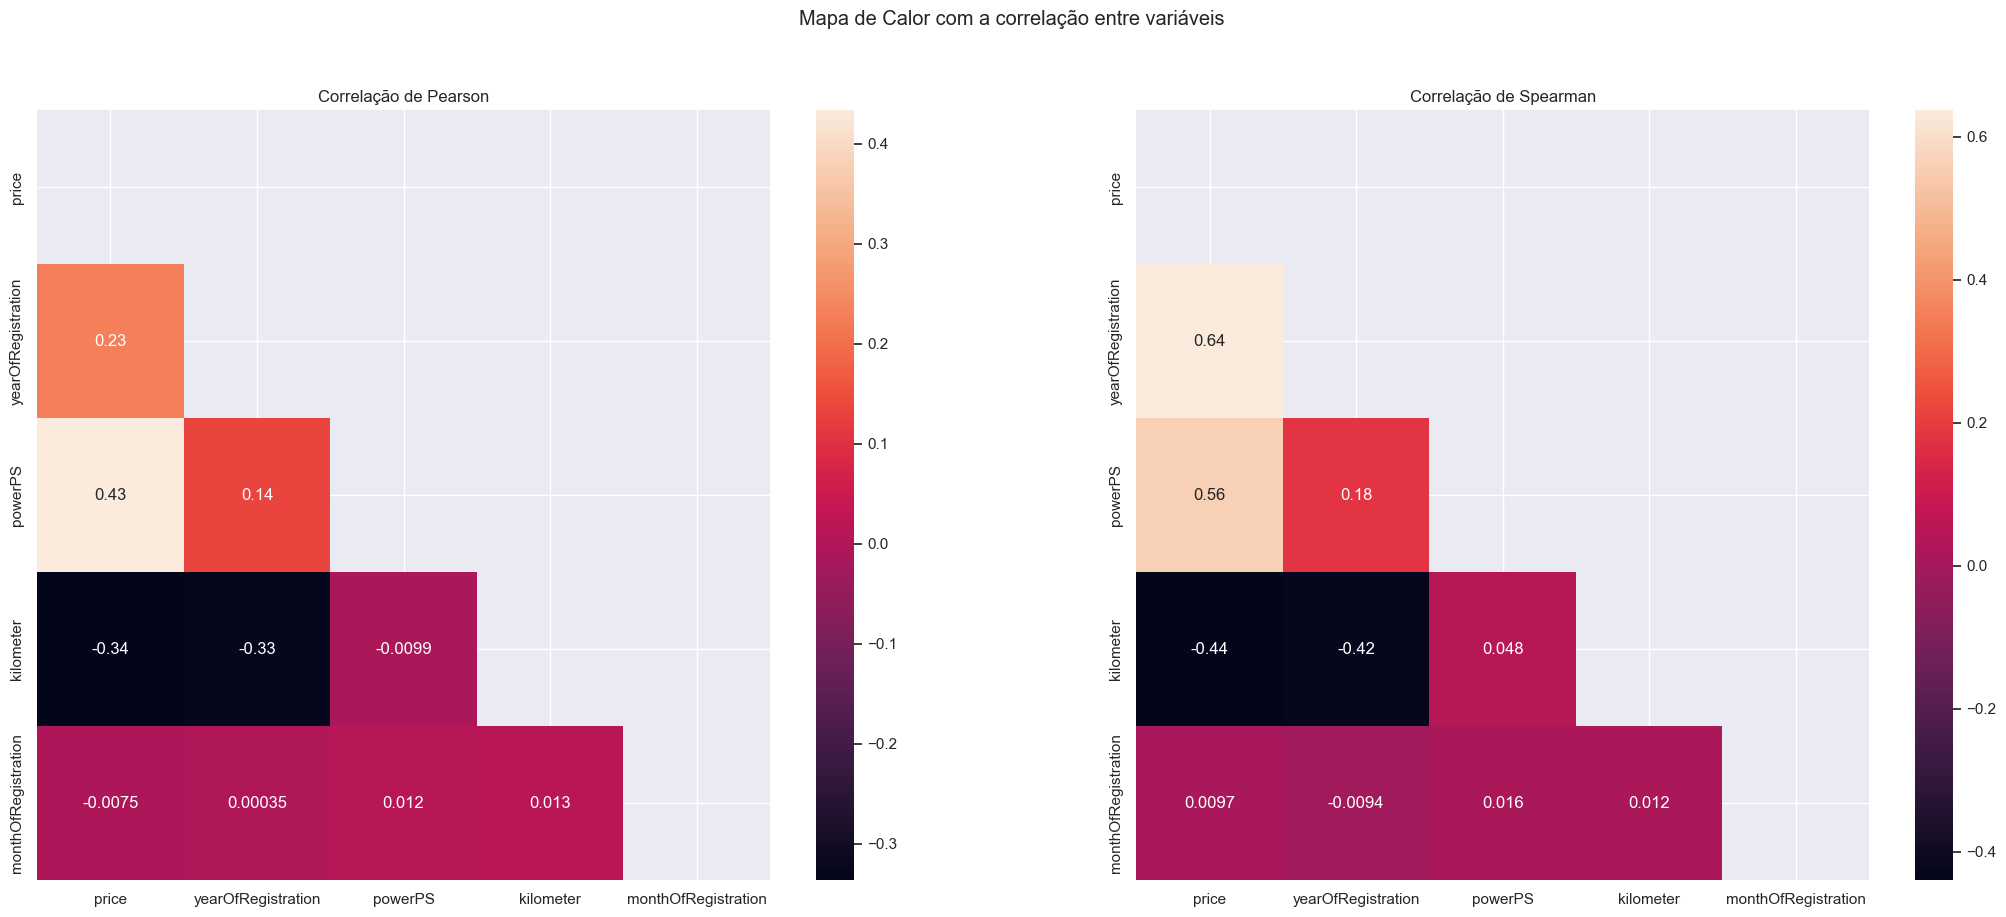

In [ ]:
# Imprimindo o heatmap
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(1, 2, figsize=(26, 10))
sns.heatmap(data=pearson, annot=True, mask=mask_pearson, ax=ax[0])
ax[0].set_title("Correlação de Pearson")
sns.heatmap(data=spearman, annot=True, mask=mask_spearman, ax=ax[1])
ax[1].set_title("Correlação de Spearman")
fig.suptitle('Mapa de Calor com a correlação entre variáveis')
fig.show()

In [ ]:
# Relembrando o nosso dataset
data.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,notRepairedDamage
1,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,ja
2,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,NaN
3,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,nein
4,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,nein
5,650,test,limousine,1995,manuell,102,3er,150000,10,benzin,ja


In [ ]:
# Copiando o dataset
data_cp = data.copy()

In [ ]:
# Inserindo as médias nos valores faltantes
from sklearn.impute import SimpleImputer

# Lide com valores ausentes (usando estratégia "most_frequent" para algumas colunas)
columns_to_impute = ['gearbox', 'model', 'fuelType', 'notRepairedDamage', 'vehicleType']
for column in columns_to_impute:
    imputer = SimpleImputer(strategy='most_frequent')
    data_cp[column] = imputer.fit_transform(data[[column]]).ravel()

# Procurando por valores vazios
data_cp.isna().sum()
print(data_cp)

        price   abtest vehicleType  yearOfRegistration    gearbox  powerPS  \
1       18300     test       coupe                2011    manuell      190   
2        9800     test         suv                2004  automatik      163   
3        1500     test  kleinwagen                2001    manuell       75   
4        3600     test  kleinwagen                2008    manuell       69   
5         650     test   limousine                1995    manuell      102   
...       ...      ...         ...                 ...        ...      ...   
352818   3200  control   limousine                2004    manuell      225   
352822   1199     test      cabrio                2000  automatik      101   
352823   9200     test         bus                1996    manuell      102   
352824   3400     test       kombi                2002    manuell      100   
352825  28990  control   limousine                2013    manuell      320   

              model  kilometer  monthOfRegistration fuelType no

In [ ]:
datadum = pd.get_dummies(data_cp)
datadum.head()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,abtest_control,abtest_test,vehicleType_andere,vehicleType_bus,vehicleType_cabrio,...,model_zafira,fuelType_andere,fuelType_benzin,fuelType_cng,fuelType_diesel,fuelType_elektro,fuelType_hybrid,fuelType_lpg,notRepairedDamage_ja,notRepairedDamage_nein
1,18300,2011,190,125000,5,False,True,False,False,False,...,False,False,False,False,True,False,False,False,True,False
2,9800,2004,163,125000,8,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,True
3,1500,2001,75,150000,6,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True
4,3600,2008,69,90000,7,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,True
5,650,1995,102,150000,10,False,True,False,False,False,...,False,False,True,False,False,False,False,False,True,False


In [ ]:
# Separando os previsores das classes
datadum = pd.get_dummies(data)
scaler_X = MinMaxScaler()
datadum = pd.DataFrame(scaler_X.fit_transform(datadum))
prev = datadum.iloc[:, 1:].values
classe = datadum.iloc[:, 0].values.reshape(-1, 1)

In [ ]:
# Dividindo os dados em treino, validação e teste
train_x, test_valid_x, train_y, test_valid_y = train_test_split(prev, classe, test_size=0.25, random_state=0)
test_x, valid_x, test_y, valid_y = train_test_split(test_valid_x, test_valid_y, test_size=0.25, random_state=0)


A função build_model_wrapper é um wrapper para criar modelos de rede neural usando o Keras Tuner.
Ela recebe um objeto hp (HyperParameters) que contém as informações sobre os hiperparâmetros a serem sintonizados.
A função utiliza esses hiperparâmetros para chamar a função build_model e retorna o modelo resultante.

A chamada para build_model passa os seguintes hiperparâmetros:

units_input: Número de unidades na camada de entrada.
activation_input: Função de ativação para a camada de entrada, escolhida entre 'relu' e 'tanh'.
kernel_initializer_input: Inicializador de pesos para a camada de entrada, escolhido entre 'random_uniform' e 'he-uniform'.
dropout_input: Taxa de dropout para a camada de entrada, variando entre 0.2 e 0.3 com incrementos de 0.1.
Em seguida, há uma seção para camadas adicionais (até três) que são controladas pelos seguintes hiperparâmetros para cada camada:

units_X: Número de unidades na camada X (onde X pode ser 0, 1 ou 2).
activation_X: Função de ativação para a camada X, escolhida entre 'relu' e 'tanh'.
kernel_initializer_X: Inicializador de pesos para a camada X, escolhido entre 'random_uniform' e 'he_uniform'.
dropout_X: Taxa de dropout para a camada X, variando entre 0.2 e 0.3 com incrementos de 0.1.
Finalmente, o hiperparâmetro learning_rate é utilizado para a taxa de aprendizado do otimizador do modelo, com opções de 1e-2, 1e-3 e 1e-4.

Quanto à função maybe_compute_model_size, ela tenta calcular o tamanho total do modelo em termos do número total de pesos treináveis.
Isso é feito somando os produtos das dimensões dos pesos treináveis da rede neural.
Se ocorrer algum erro durante esse cálculo, a função lança uma exceção do tipo RuntimeError com uma mensagem indicando a natureza do problema.

In [ ]:
def build_model_wrapper(hp):
    model = Sequential()

    # Camada de entrada
    model.add(Dense(units=hp.Int('units_input', min_value=4, max_value=512, step=8),
                    activation=hp.Choice('activation_input', values=['relu', 'tanh']),
                    kernel_initializer='he_uniform',
                    input_dim=train_x.shape[1]))
    model.add(Dropout(hp.Float('dropout_input', min_value=0.2, max_value=0.3, step=0.1)))

    # Camadas ocultas
    for i in range(hp.Int('num_layers', min_value=1, max_value=4)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=4, max_value=512, step=8),
                        activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh']),
                        kernel_initializer='he_uniform',
                        ))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.3, step=0.1)))

    # Camada de saída
    model.add(Dense(1, activation='linear'))

    # Compilando o modelo
    optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    if optimizer == 'adam':
        model.compile(
            optimizer=Adam(learning_rate),
            loss='mape',
            metrics=['mae']
        )
    elif optimizer == 'sgd':
        model.compile(
            optimizer=SGD(learning_rate),
            loss='mape',
            metrics=['mae']
        )
    else:
        raise ValueError(f"Otimizador não suportado: {optimizer}")

    return model


# Função para calcular o tamanho do modelo
def maybe_compute_model_size(model):
    try:
        return sum([np.prod(p.shape) for p in model.trainable_weights])
    except Exception as e:
        raise RuntimeError("Erro ao calcular o tamanho do modelo: {}".format(e))



Neste trecho, estou criando um sintonizador (tuner) para otimizar os hiperparâmetros do modelo usando o método de busca aleatória.
O sintonizador é do tipo RandomSearch, uma abordagem que explora de forma aleatória o espaço de hiperparâmetros para encontrar configurações ótimas.

build_model_wrapper é a função que define a arquitetura do modelo e é a função que será otimizada pelo sintonizador.
Ela encapsula a construção do modelo utilizando os hiperparâmetros especificados.

objective='val_mae' define a métrica que o sintonizador tentará otimizar.
Neste caso, a métrica escolhida é o erro absoluto médio (val_mae) no conjunto de validação.

max_trials=10 especifica o número máximo de configurações de hiperparâmetros a serem avaliadas pelo sintonizador.
O sintonizador realizará no máximo 10 tentativas para encontrar a melhor configuração.

seed=42 é uma semente para a reprodução, garantindo que os resultados possam ser reproduzidos.

directory='my_dir3' e project_name='autos' definem o diretório onde os resultados do sintonizador serão armazenados. Isso é útil para revisar e comparar diferentes experimentos.

Em resumo, este trecho cria um sintonizador RandomSearch para ajustar os hiperparâmetros do modelo, utilizando a função build_model_wrapper como base, e visa otimizar o desempenho do modelo em termos do erro absoluto médio no conjunto de validação.

In [ ]:
# Criando o tuner
tuner = RandomSearch(
    build_model_wrapper,
    objective='val_mae',
    max_trials=10,
    seed=42,
    directory='my_dir3',
    project_name='autos'
)

Reloading Tuner from my_dir3\autos\tuner0.json


In [ ]:
# Realizando a busca de hiperparâmetros
tuner.search(train_x, train_y, epochs=10, validation_data=(valid_x, valid_y))


Trial 10 Complete [00h 00m 00s]

Best val_mae So Far: 0.004894283600151539
Total elapsed time: 00h 25m 41s


In [ ]:
# Obtendo os melhores hiperparâmetros e a melhor precisão
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_precision = tuner.oracle.get_best_trials(num_trials=1)[0].score

In [ ]:
# Imprimindo os melhores parâmetros e a melhor precisão
print("Melhores Parâmetros:", best_hps.values)
print("Melhor Precisão:", best_precision)

Melhores Parâmetros: {'units_input': 444, 'activation_input': 'relu', 'kernel_initializer_input': 'he-uniform', 'dropout_input': 0.2, 'num_layers': 1, 'units_0': 420, 'activation_0': 'tanh', 'kernel_initializer_0': 'he_uniform', 'dropout_0': 0.2, 'optimizer': 'adam', 'learning_rate': 0.001, 'units_1': 252, 'activation_1': 'tanh', 'kernel_initializer_1': 'he_uniform', 'dropout_1': 0.2, 'units_2': 60, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_uniform', 'dropout_2': 0.2, 'units_3': 52, 'activation_3': 'relu', 'kernel_initializer_3': 'random_uniform', 'dropout_3': 0.2}
Melhor Precisão: 0.004894283600151539


In [ ]:
# Criando o modelo com os melhores hiperparâmetros usando a função wrapper
model = build_model_wrapper(best_hps)


In [ ]:
# Treinando o modelo
history = model.fit(train_x, train_y, epochs=100, validation_data=(valid_x, valid_y))



Epoch 1/100
6415/6415 [==============================] - 20s 3ms/step - loss: 1006577.9375 - mae: 0.0800 - val_loss: 68858.5703 - val_mae: 0.0067
Epoch 2/100
6415/6415 [==============================] - 20s 3ms/step - loss: 39092.8750 - mae: 0.0074 - val_loss: 26792.8008 - val_mae: 0.0055
Epoch 3/100
6415/6415 [==============================] - 20s 3ms/step - loss: 34791.2539 - mae: 0.0072 - val_loss: 223934.5781 - val_mae: 0.0222
Epoch 4/100
6415/6415 [==============================] - 19s 3ms/step - loss: 29292.9492 - mae: 0.0069 - val_loss: 2963.4419 - val_mae: 0.0062
Epoch 5/100
6415/6415 [==============================] - 20s 3ms/step - loss: 34565.1328 - mae: 0.0073 - val_loss: 41544.3672 - val_mae: 0.0092
Epoch 6/100
6415/6415 [==============================] - 19s 3ms/step - loss: 32699.7949 - mae: 0.0071 - val_loss: 145532.6562 - val_mae: 0.0078
Epoch 7/100
6415/6415 [==============================] - 19s 3ms/step - loss: 29888.8945 - mae: 0.0071 - val_loss: 56815.0820 - val_m

In [ ]:
# Obtendo a precisão do modelo no conjunto de validação
val_mape = history.history['val_loss'][-1]
val_mae = history.history['val_mae'][-1]

In [ ]:
# Imprimindo as métricas
print(f"MAPE no conjunto de validação: {val_mape}")
print(f"MAE no conjunto de validação: {val_mae}")


MAPE no conjunto de validação: 3164.799560546875
MAE no conjunto de validação: 0.005889764986932278


O gráfico de saída mostra um resultado com aparente eficácia, mostrando leves variações ao longo gráfico sem "travar valores" devido a um possível overfit.

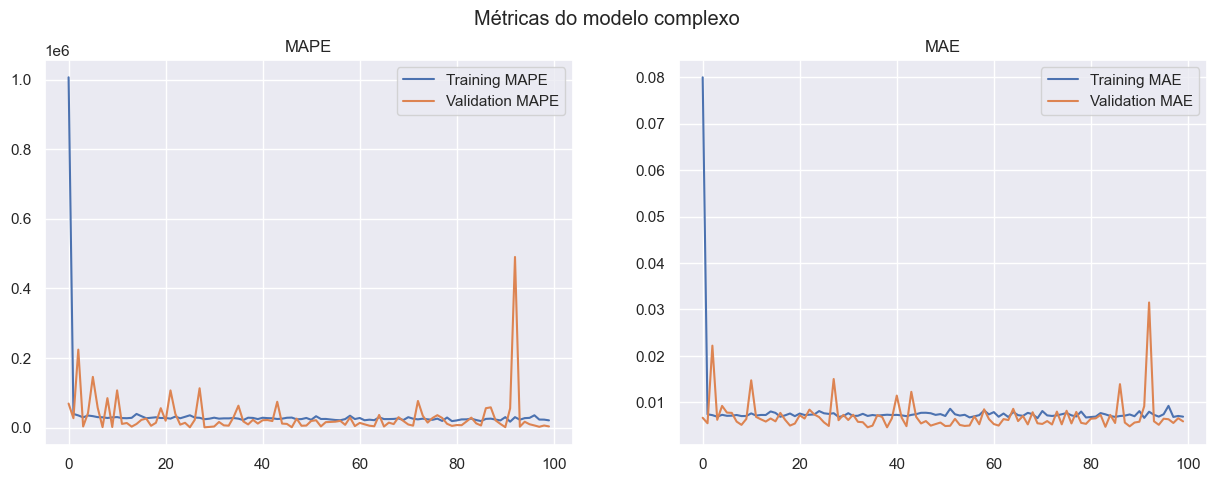

In [ ]:
import matplotlib.pyplot as plt

# Função para plotar o histórico de treinamento com MAPE e MAE
def plot_history(history, title):
    # Criando subplots
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Plotando MAPE
    axs[0].plot(history.history['loss'], label='Training MAPE')
    axs[0].plot(history.history['val_loss'], label='Validation MAPE')
    axs[0].set_title('MAPE')
    axs[0].legend()

    # Plotando MAE
    axs[1].plot(history.history['mae'], label='Training MAE')
    axs[1].plot(history.history['val_mae'], label='Validation MAE')
    axs[1].set_title('MAE')
    axs[1].legend()

    # Adicionando título geral
    fig.suptitle(title)

    # Exibindo os gráficos
    plt.show()

# Chamando a função para plotar o histórico
plot_history(history, title_large)

In [ ]:
from keras.models import model_from_json

# Salvar a estrutura da rede em um arquivo JSON
modelo_json = model.to_json()
with open("estrutura_modelo_tuner.json", "w") as json_file:
    json_file.write(modelo_json)

# Salvar os pesos da rede em um arquivo H5 (como você já estava fazendo)
model.save('modelo_tuner.h5')

C:\Users\as_pc\anaconda3\envs\REGRESS\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
